# Publications, datasets, and software by a particular researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [0]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("RColorBrewer")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'igraph'

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [0]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

query <- '{
  person(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    softwareSourceCodes(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
  }
}'

In [0]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [0]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$person$name)

Martin Fenner

In [0]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwareSourceCodes$totalCount)

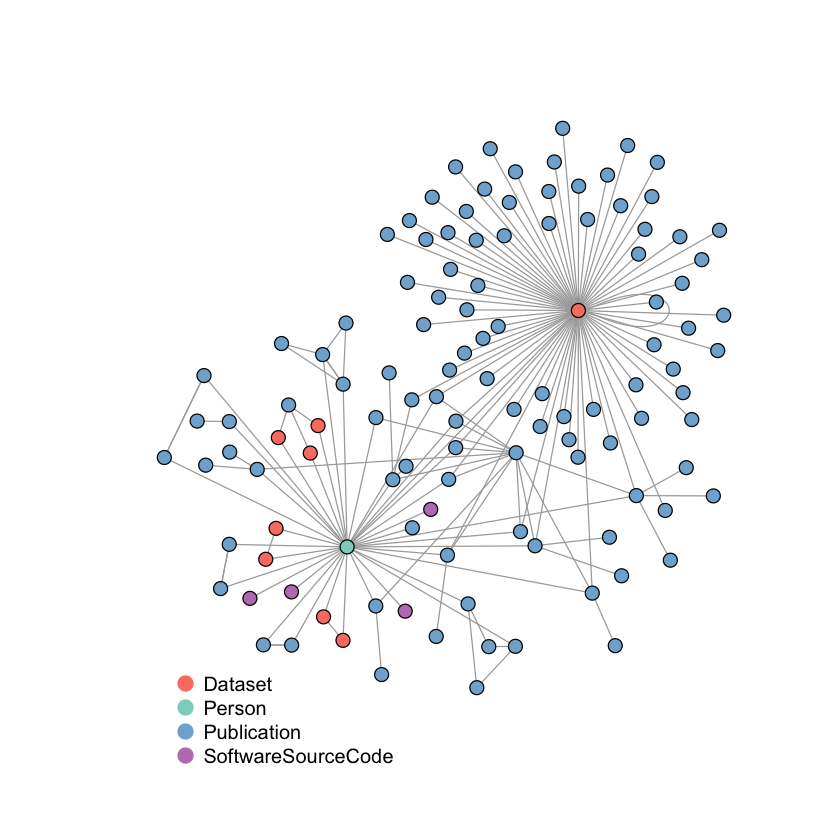

In [0]:
# generate data frame for nodes
people <- data.frame(id=data$data$person$id, pid_type=data$data$person$type)
publications <- data.frame(id=data$data$person$publications$nodes$id, pid_type=c('Publication'))
datasets <- data.frame(id=data$data$person$datasets$nodes$id, pid_type=data$data$person$datasets$nodes$type)
softwareSourceCodes <- data.frame(id=data$data$person$softwareSourceCodes$nodes$id, pid_type=data$data$person$softwareSourceCodes$nodes$type)
publication_references <- data.frame(id=bind_rows(data$data$person$publications$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
dataset_references <- data.frame(id=bind_rows(data$data$person$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
#software_references <- data.frame(id=bind_rows(data$data$person$softwareSourceCodes$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
nodes <- unique(rbind(people, publications, datasets, softwareSourceCodes, publication_references, dataset_references))

publication_edges <- data.frame(to=publications[,1], from=data$data$person$id)
dataset_edges <- data.frame(to=datasets[,1], from=data$data$person$id)
software_edges <- data.frame(to=softwareSourceCodes[,1], from=data$data$person$id)
edges <- unique(rbind(publication_edges, dataset_edges, software_edges))
    
# loop through nodes, as they can have more than one edge
publications_with_references <- bind_rows(data$data$person$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
datasets_with_references <- bind_rows(data$data$person$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
softwareSourceCodes_with_references <- bind_rows(data$data$person$softwareSourceCodes$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(publications_with_references)) {
  row <- data.frame(to=unlist(publications_with_references[i,3]), from=publications_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

for (i in 1:nrow(datasets_with_references)) {
  row <- data.frame(to=unlist(datasets_with_references[i,3]), from=datasets_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

#for (i in 1:nrow(softwareSourceCodes_with_references)) {
#  row <- data.frame(to=unlist(softwareSourceCodes_with_references[i,3]), from=softwareSourceCodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$pid_type=="Publication")]$color<-cols[5]
V(g)[(V(g)$pid_type=="Person")]$color<-cols[1]
V(g)[(V(g)$pid_type=="Dataset")]$color<-cols[4]
V(g)[(V(g)$pid_type=="SoftwareSourceCode")]$color<-cols[10]

# add labels to selected nodes
V(g)$label=NA

V(g)$size <- 5
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
# pid_type is sorted alphabetically: 'Dataset' 'Person' 'Publication' 'SoftwareSourceCode'
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = cols[c(4,1,5,10)], bty = "n", pch=20 , pt.cex = 2.5, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

In [0]:
# Generate a list of formatted citations in APA format for the publications, datasets and software

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

ids <- substring(datasets[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Datasets')
display_markdown(content(response, as = 'text'))

ids <- substring(softwareSourceCodes[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Software')
display_markdown(content(response, as = 'text'))

## Publications

Fenner, M. (2016, November 3). A common API for retrieving DataCite Metadata. https://doi.org/10.5438/6WCF-EFW5

Fenner, M., &amp; Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015, December 28). Announcing the DataCite Blog Relaunch. https://doi.org/10.5438/XCBJ-G7ZY

Fenner, M. (2016, April 14). It's all about Relations. https://doi.org/10.5438/PE54-ZJ5T

Fenner, M. (2015, October 1). Thoughts on the Research Data Alliance 6th Plenary. https://doi.org/10.5438/7RXD-S8A3

Fenner, M. (2016, January 11). Launching the DataCite Status Page. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M. (2015, September 18). Differences between ORCID and DataCite Metadata. https://doi.org/10.5438/BC11-CQW1

Fenner, M. (2016, March 30). DataCite is Hiring an Application Developer. https://doi.org/10.5438/MSK0-15R2

Fenner, M. (2016, July 5). Relaunching DataCite Search. https://doi.org/10.5438/VQ2T-VR4K

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. <i>Figshare</i>. https://doi.org/10.23640/07243.5153971

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120261

Burton, A., Fenner, M., Haak, W., &amp; Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120265

Fenner, M., &amp; Hallett, R. (2018, January 18). Welcome to the DataCite Team, Richard! https://doi.org/10.5438/PRVV-NV23

Fenner, M. (2015, August 3). Data-Driven Development. https://doi.org/10.5438/DHSM-8219

Dasler, R., &amp; Fenner, M. (2018, May 13). Welcome to the DataCite Team, Robin! https://doi.org/10.5438/4CNA-AQ40

Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1250025

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297432

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297431

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324300

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324299

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324296

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324295

Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554875

Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554874

Fenner, M. (2019, May 27). Using Jupyter Notebooks with GraphQL and the PID Graph. https://doi.org/10.5438/HWAW-XE52

## Datasets

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828.V1

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST Kickoff report</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>D2.2 Kickoff report</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V2

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST do not use!!</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V3

Fenner, M. (2015). <i>DataCite Mandatory Properties</i> [Data set]. DataCite. https://doi.org/10.5438/EA4H-TX3G

## Software

Fenner, M. (2017, April 28). Content-Negotation: an API for DOI content negotiation. DataCite. https://doi.org/10.5438/T1JG-HVHN

Fenner, M. (2019, June 30). FREYA PID Graph Key Performance Indicators (KPIs) (Version 1.1.0). DataCite. https://doi.org/10.14454/3BPW-W381

Fenner, M. (2019). Omniauth-globus: provides basic support for authenticating a client application via the Globus service. <i>DataCite</i>. https://doi.org/10.14454/81GP-9Y63

Fenner, M. (2019, October 12). FREYA PID Graph for a specific researcher (Version 1.0.0). DataCite. https://doi.org/10.14454/628M-3882

In [0]:
# Generate a list of formatted citations in APA format for the references (if they are DataCite DOIs)

ids <- publication_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publication References')
display_markdown(content(response, as = 'text'))

ids <- dataset_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Dataset References')
display_markdown(content(response, as = 'text'))  

## Publication References

Unbekannt. (1931). <i>Hannover, Blick auf Hannover</i>. ETH-Bibliothek Zürich, Bildarchiv. https://doi.org/10.3932/ETHZ-A-000159123

DataCite Metadata Working Group. (2014). DataCite Metadata Schema for the Publication and Citation of Research Data v3.1. <i>DataCite E.V.</i> https://doi.org/10.5438/0010

Fenner, M., Demeranville, T., Kotarski, R., Vision, T., Rueda, L., Dasler, R., … Cruse, P. (2015). <i>D2.1: Artefact, Contributor, And Organisation Relationship Data Schema</i>. Zenodo. https://doi.org/10.5281/ZENODO.30799

Mayo, C., Hull, E. A., &amp; Vision, T. J. (2015). The Location Of The Citation: Changing Practices In How Publications Cite Original Data In The Dryad Digital Repository. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.32412

Dasler, R. (2016). <i>Thor: Metrics And Tools</i>. Zenodo. https://doi.org/10.5281/ZENODO.46761

Fenner, M., Wass, J., Song, J., Dennis, Z., Whitwell, M., Osowski, J., … Chodacki, J. (2016, April 12). Lagotto 5.0.1. Zenodo. https://doi.org/10.5281/ZENODO.49516

Fenner, M. (2016, December 23). Mysteries in Reference Lists. https://doi.org/10.5438/CT8B-X1CE

Cruse, P., Rueda, L., Garza, K., &amp; Fenner, M. (2015, August 3). DataCite Blog (Version 1.0). DataCite. https://doi.org/10.5438/0000-00SS

Burton, A., Fenner, M., Haak, W., Koers, H., &amp; Manghi, P. (2016). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1120248

La Bruzzo, S., &amp; Manghi, P. (2017, November 21). The Scholix Metadata Schema (Json And Xml). Zenodo. https://doi.org/10.5281/ZENODO.1120275

Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1250026

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297432

Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., &amp; Fenner, M. (2018). Status Quo And Perspective Of Re3Data. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1297431

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324300

Wimalaratne, S., &amp; Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324299

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324296

Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.1324295

Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554875

Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554874

Fenner, M., &amp; Aryani, A. (2019, March 28). Introducing the PID Graph. https://doi.org/10.5438/JWVF-8A66

Fenner, M. (2019, May 15). The DataCite GraphQL API is now open for (pre-release) business. https://doi.org/10.5438/QAB1-N315

Garza, K., Goble, C., Brooke, J., &amp; Jay, C. (2015). Framing the community data system interface. <i>Association for Computing Machinery (ACM)</i>. https://doi.org/10.1145/2783446.2783605

Chen, X., Dallmeier-Tiessen, S., Dani, A., Dasler, R., Fernández, J. D., Fokianos, P., … Šimko, T. (2016). CERN Analysis Preservation: A Novel Digital Library Service to Enable Reusable and Reproducible Research. Springer International Publishing. https://doi.org/10.1007/978-3-319-43997-6_27

Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. In <i>Communications in Computer and Information Science</i>. Springer International Publishing. https://doi.org/10.1007/978-3-030-11226-4_7

## Dataset References

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. Figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

Cruse, P. (2016, October 14). DataCite Welcomes TIND. https://doi.org/10.5438/1YAA-K6D1

Katz, D. S. (2016, April 17). To better understand research communication, we need a GROUPID (group object identifier). https://doi.org/10.5438/SHR4-2BS2

Fenner, M. (2015, August 17). From Pilot to Service. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2016). Eating your own Dog Food. https://doi.org/10.5438/4K3M-NYVG

Fenner, M. (2016, November 3). A common API for retrieving DataCite Metadata. https://doi.org/10.5438/6WCF-EFW5

Rueda, L. (2016, September 1). PIDapalooza, the festival of persistent identifiers is coming soon! https://doi.org/10.5438/PRF0-NRXQ

Pampel, H. (2016, April 13). re3data.org Reaches a Milestone and Begins Offering Badges. https://doi.org/10.5438/KTR7-ZJJH

Fenner, M. (2015, August 15). Reference Lists and Tables of Content. https://doi.org/10.5438/5AEG-WEEV

Rueda, L. (2016, September 20). Software Citation Principles. https://doi.org/10.5438/WMAS-KM0V

Fenner, M. (2015). <i>DataCite Mandatory Properties</i> [Data set]. DataCite. https://doi.org/10.5438/EA4H-TX3G

Rueda, L. (2016, December 19). 2016 in review. https://doi.org/10.5438/ZWSF-4Y7Y

Fenner, M. (2015). Software Citation Workflows. https://doi.org/10.5438/1H7N-3CEN

Fenner, M. (2015, October 26). Auto-Update Has Arrived! https://doi.org/10.5438/FERW-CWHQ

Hull, E. (2016, March 28). The Location of the Citation: are Data Citation Recommendations Having an Effect? https://doi.org/10.5438/F17B-45VZ

Fenner, M., &amp; Garza, K. (2016). Announcing Our New Application Developer. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015, September 16). Adding References to the DataCite Blog. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016, December 15). Cool DOI's. https://doi.org/10.5438/55E5-T5C0

Cruse, P. (2016, May 18). Get involved in the DataCite Community! https://doi.org/10.5438/MRR6-MF3Q

Fenner, M. (2015, September 22). Persistent Identifiers: Enabling Services for Data Intensive Research. https://doi.org/10.5438/JM9F-325F

Cruse, P. (2016). DataCite’s New Membership Model - Join Us! https://doi.org/10.5438/8SZS-1H0H

Lin, J. (2015). When Counting is Hard. <i>DataCite Blog</i>. https://doi.org/10.5438/02BH-TGC7

Fenner, M. (2015, December 23). Infrastructure Tips for the Non-Profit Startup. https://doi.org/10.5438/T0AP-D5W7

Fenner, M. (2015). Discussing the Scholarly Container. https://doi.org/10.5438/D9EQ-9DGA

Rueda, L. (2016, May 17). Zotero for Data Repositories Webinar. https://doi.org/10.5438/Q2GH-6EGD

Fenner, M. (2015, December 28). Announcing the DataCite Blog Relaunch. https://doi.org/10.5438/XCBJ-G7ZY

Cruse, P. (2015, November 2). DataCite Is an Exciting Place to Be. https://doi.org/10.5438/GA8V-FA94

Rueda, L. (2016, October 24). The Tsinghua University Library joins DataCite. https://doi.org/10.5438/ESYS-F867

Fenner, M. (2015). Overcoming Development Pain (Version 1.0). https://doi.org/10.5438/8QKH-1R6~

Jensen, L. J. (2016, May 1). Tip: Getting data into Impactstory but not your ORCID profile. https://doi.org/10.5438/78P9-FNRN

Fenner, M. (2015, November 9). Announcing the DataCite Profiles Service. https://doi.org/10.5438/15X1-BJ6R

Pampel, H. (2016, February 24). Enhancements to creating and updating re3data. https://doi.org/10.5438/6GEP-3S5E

Fenner, M. (2016, May 4). Thinking about CSV. https://doi.org/10.5438/4QX3-RP8Y

Witt, M. (2016, January 20). New re3data.org Schema and Search Functionality. https://doi.org/10.5438/4BY7-B7ZN

Fenner, M. (2015). Data-Driven Development. https://doi.org/10.5438/5PS5-G3V~

Cruse, P. (2015, October 4). Recap: Persistent Identifiers in Paris. https://doi.org/10.5438/85SN-MX23

Rueda, L. (2016, July 8). DataCite Metadata Schema 4.0 Webinar. https://doi.org/10.5438/X4JQ-EGT5

Rueda, L. (2015, December 5). DataCite Profiles and ORCID Auto-Update webinar. https://doi.org/10.5438/CJT2-T6DZ

Fenner, M. (2015, September 3). Using YAML Frontmatter with CSV. https://doi.org/10.5438/5HZJ-5KDS

Fenner, M. (2016, April 14). It's all about Relations. https://doi.org/10.5438/PE54-ZJ5T

Fenner, M. (2015, October 1). Thoughts on the Research Data Alliance 6th Plenary. https://doi.org/10.5438/7RXD-S8A3

Cruse, P. (2016, October 17). Welcome United States Geological Survey (USGS). https://doi.org/10.5438/9JWD-TN3A

Fenner, M. (2016, May 13). Data catalog cards: simplifying article/data linking. https://doi.org/10.5438/CAB5-TEG0

Cruse, P. (2016, March 31). General Assembly 2016, moving DataCite forward. https://doi.org/10.5438/C81T-HKVP

Fenner, M. (2015, September 9). Announcing Data-Level Metrics in DataCite Labs. https://doi.org/10.5438/JZG5-VCQV

Fenner, M. (2016, November 1). Announcing the Organization Identifier Project: a Way Forward. https://doi.org/10.5438/TNHX-54CG

Fenner, M. (2016, July 18). Dynamic Data Citation Webinar. https://doi.org/10.5438/Y4KS-KSBC

Fenner, M. (2015, October 16). Happy Birthday ORCID. https://doi.org/10.5438/C61Q-Z2K7

Castro, E. (2016, March 30). Dataverse is now minting DOIs with DataCite Metadata Store API. https://doi.org/10.5438/BMMQ-YCE9

Rueda, L. (2016, September 21). New DataCite Metadata Schema 4.0. https://doi.org/10.5438/VQ3X-QDWT

Fenner, M. (2015, August 20). Digging into Metadata using R. https://doi.org/10.5438/1HV8-2GC2

Fenner, M. (2015, October 29). Explaining the DataCite/ORCID Auto-update. https://doi.org/10.5438/3DFW-Z4KQ

Fenner, M. (2016, January 11). Launching the DataCite Status Page. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M. (2015, September 18). Differences between ORCID and DataCite Metadata. https://doi.org/10.5438/BC11-CQW1

Fenner, M. (2016, March 30). DataCite is Hiring an Application Developer. https://doi.org/10.5438/MSK0-15R2

Fenner, M. (2016, July 5). Relaunching DataCite Search. https://doi.org/10.5438/VQ2T-VR4K

Rueda, L. (2016, June 27). Our New Website: Dynamic, Responsive and Adapted to your Needs. https://doi.org/10.5438/QW2X-PGCY

Fenner, M. (2015). Contributor Information in DataCite Metadata. <i>DataCite Blog</i>. https://doi.org/10.5438/W029-Y6W~

Rueda, L. (2016, March 11). Open Science, Open Data and DataCite DOIs. https://doi.org/10.5438/SS2R-9CNS

Fenner, M. (2016, April 19). We were out in Force. https://doi.org/10.5438/C3BY-VYZS

Witt, M. (2015, November 25). re3data Webinar and DataCite: En Avant! https://doi.org/10.5438/MCNV-GA6N

Fenner, M. (2016, December 23). Mysteries in Reference Lists. https://doi.org/10.5438/CT8B-X1CE

Rueda, L. (2016, February 18). DataCite to Dublin Core application profile (DC2AP). https://doi.org/10.5438/0000-040H

Fenner, M. (2017, January 9). Using Schema.org for DOI Registration. https://doi.org/10.5438/0000-00CC

Rueda, L. (2017, March 2). Welcoming Children’s Hospital of Philadelphia to the community! https://doi.org/10.5438/0000-9G41

Cruse, P. (2017, March 30). The OI Project gets underway planning an Open Organization Identifier Registry. https://doi.org/10.5438/0000-0C2G

Witt, M. (2017, April 19). DataCite’s re3data wins Oberly Award from the American Libraries Association. https://doi.org/10.5438/0001-0HN*

Cruse, P. (2017, April 23). Welcome DataCite’s New Executive Board Members. https://doi.org/10.5438/0000-16JD

Rueda, L. (2017, May 18). Make Data Count: Building a System to Support Recognition of Data as a First Class Research Output. https://doi.org/10.5438/028A-CXTC